In [1]:
suppressMessages({library("rwwa"); library(quantreg)})

In [5]:
gmst <- read.table("data/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2026]

In [ ]:
df <- merge(read.csv("data/ts_pr_era5x_Kris.csv", col.names = c("time", "pr_n")),
            read.csv("data/ts_pr_era5x_LeMa.csv", col.names = c("time", "pr_s")))
df <- merge(df, gmst)

df$year <- as.integer(substr(df$time,1,4))
df$month <- as.integer(substr(df$time,6,7))
df <- df[df$time <= "2026-02-09",] # ERA5 forecast is very high - had huge leverage in model

# df <- df[df$year >= 1979,]

In [ ]:
print("!")

In [ ]:
prep_window(res = 120, h = 7, w = 7)

pairs(df[,-(1:2)], lower.panel = panel.cor)

In [ ]:
rx1day = aggregate(df[,c("pr_n", "pr_s", "gmst")], by = list(year = df$year), FUN = "max")

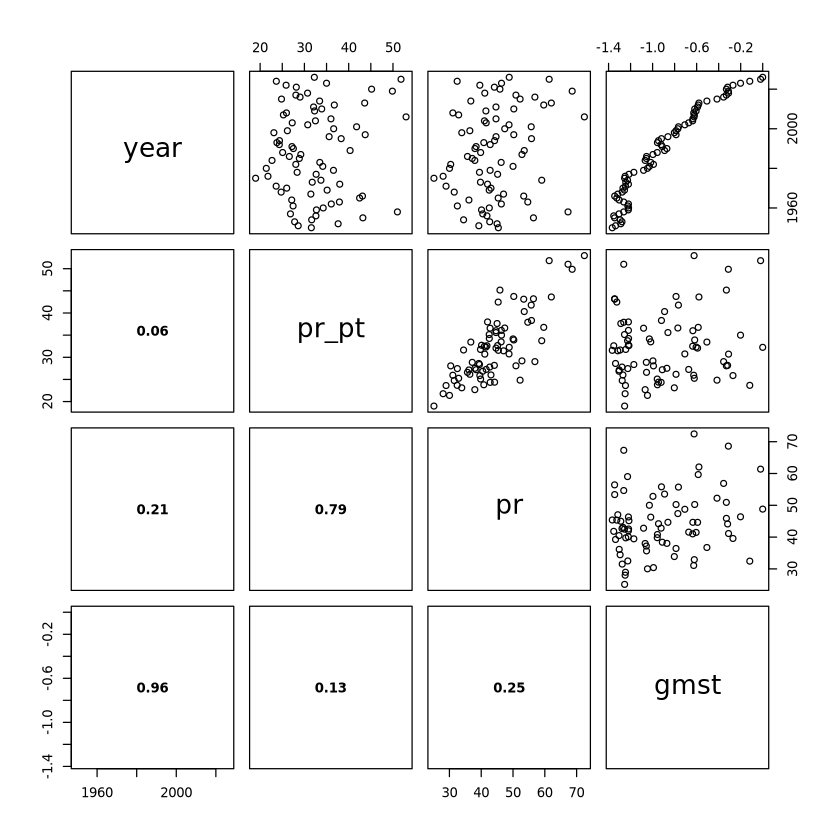

In [178]:
pairs(rx1day, lower.panel = panel.cor) # possible stronger relationship in northern Portugal? Still not very strong though, but will start there

# quick GEV fit

In [179]:
mdl_gmst <- fit_ns("gev", "fixeddisp", data = rx1day, varnm = "pr", covnm = "gmst")

cov_2026 <- gmst[gmst$year == 2026,"gmst",drop = F]
cov_cf <- data.frame("pi" = cov_2026 - 1.3)

,mdl_ests.mdl_gmst..cov_f...cov_2026..cov_cf...cov_cf.
,<dbl>
mu0,45.7816541
sigma0,9.3019515
alpha_gmst,6.2927641
shape,-0.1226718
disp,0.2031808
event_magnitude,48.8043200
return_period,1.9525075
PR,2.5103751
dI_abs,7.9859721


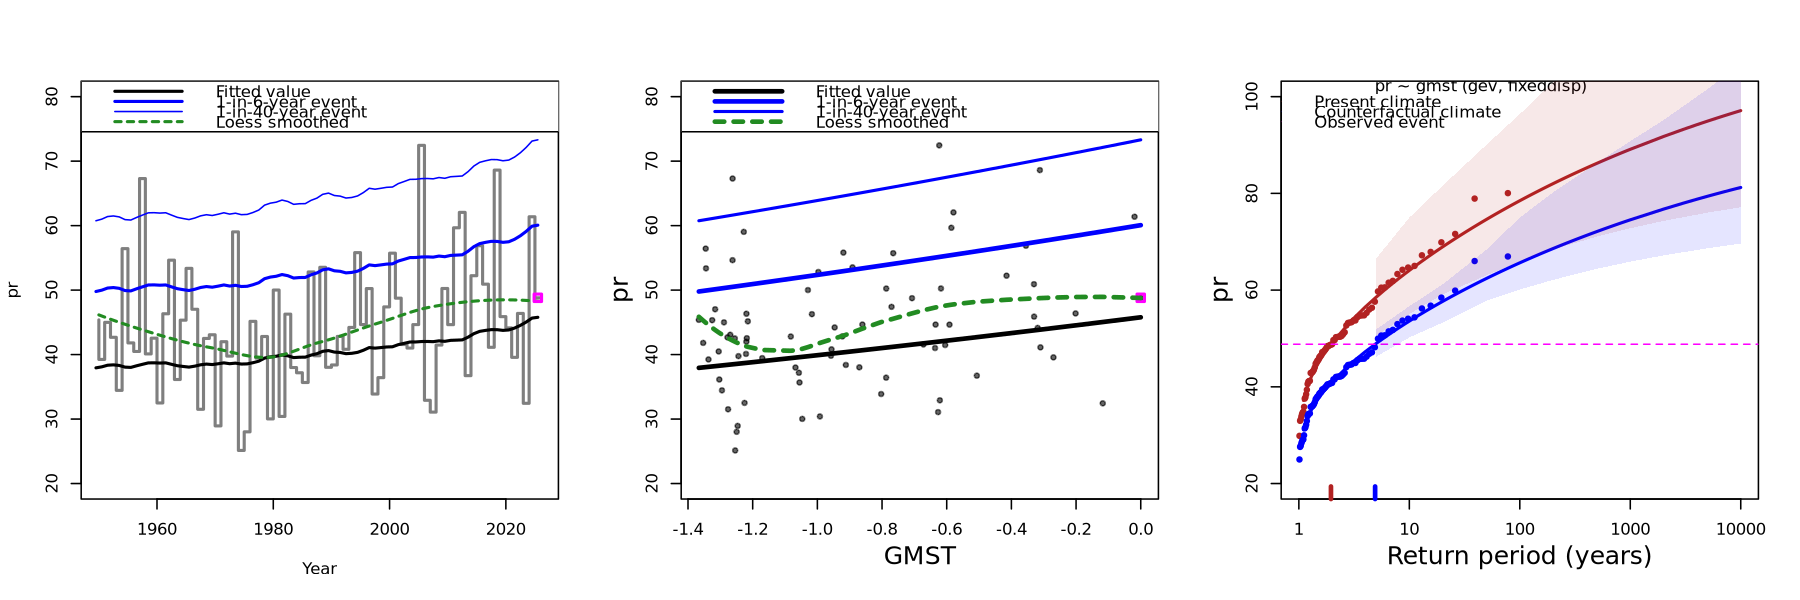

In [180]:
prep_window(c(1,3), res = 150)

plot_trend(mdl_gmst)
plot_covtrend(mdl_gmst, "gmst")
plot_returnlevels(mdl_gmst, cov_f = cov_2026, cov_cf = cov_cf, nsamp = 50)

data.frame(mdl_ests(mdl_gmst, cov_f = cov_2026, cov_cf = cov_cf))

# Peaks over thresholds

## Sensitivity to threshold

In [157]:
qq <- quantile(df[(df$year >= 1990) & (df$year <= 2020), "pr"], c(0.95, .99, .995, .9975, .999))
qq

95%      99%    99.5%   99.75%    99.9% 
15.48184 30.28663 37.02481 41.36869 50.24799

Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”
Warning message in log(z):
“NaNs produced”


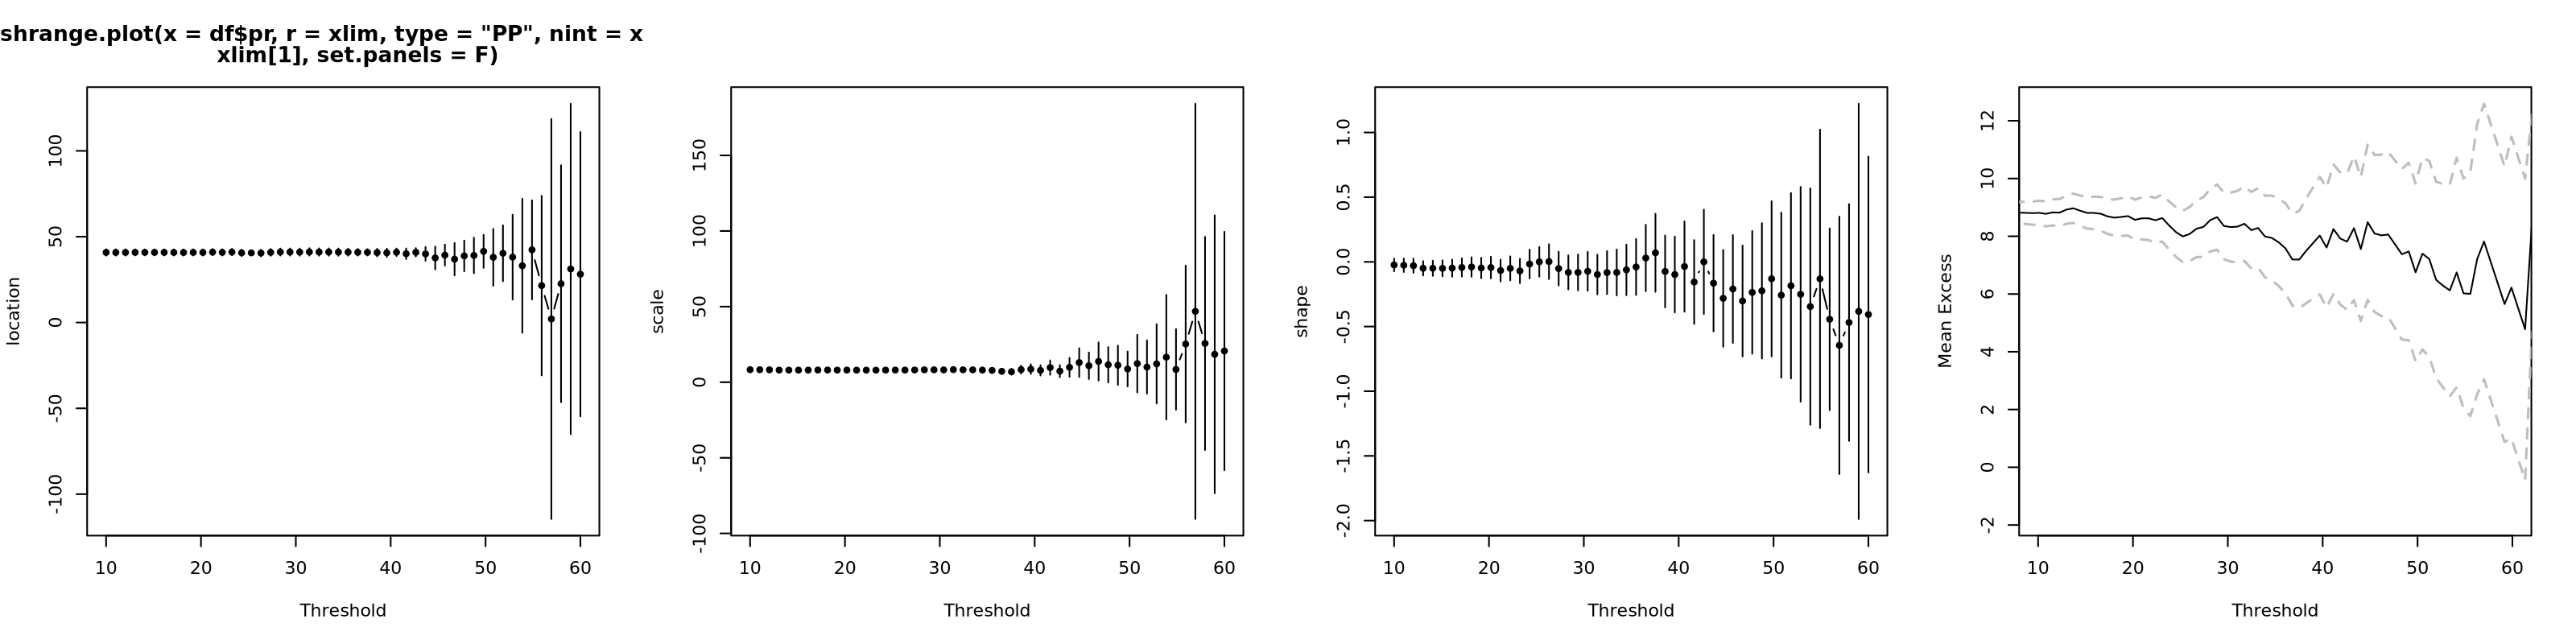

In [158]:
prep_window(c(1,4))

xlim = c(10,60)

threshrange.plot(df$pr, r = xlim, nint = xlim[2]-xlim[1], set.panels = F, type = "PP")
mrlplot(df$pr, xlim = xlim)

# anywhere from 30-40 looks like a reasonable choice: 99-99.75%

## Trends in exceedances

In [159]:
df_x <- df[df$pr >= qq["99%"],]

In [160]:
n_peryear <- aggregate(df$pr >= qq["99%"], by = list("year" = df$year), FUN = "sum", simplify = T)
n_perymonth <- aggregate(df$pr >= qq["99%"], by = list(df$month, df$year), FUN = "sum", simplify = T)
n_permonth <- aggregate(n_perymonth[,"x",drop = F], by = list("cmonth" = n_perymonth$Group.1), FUN = "mean")
n_permonth$m_offset <- ((n_permonth$cmonth + 4) %% 12) + 1 # adjust months to cut at start of August (driest part of year)

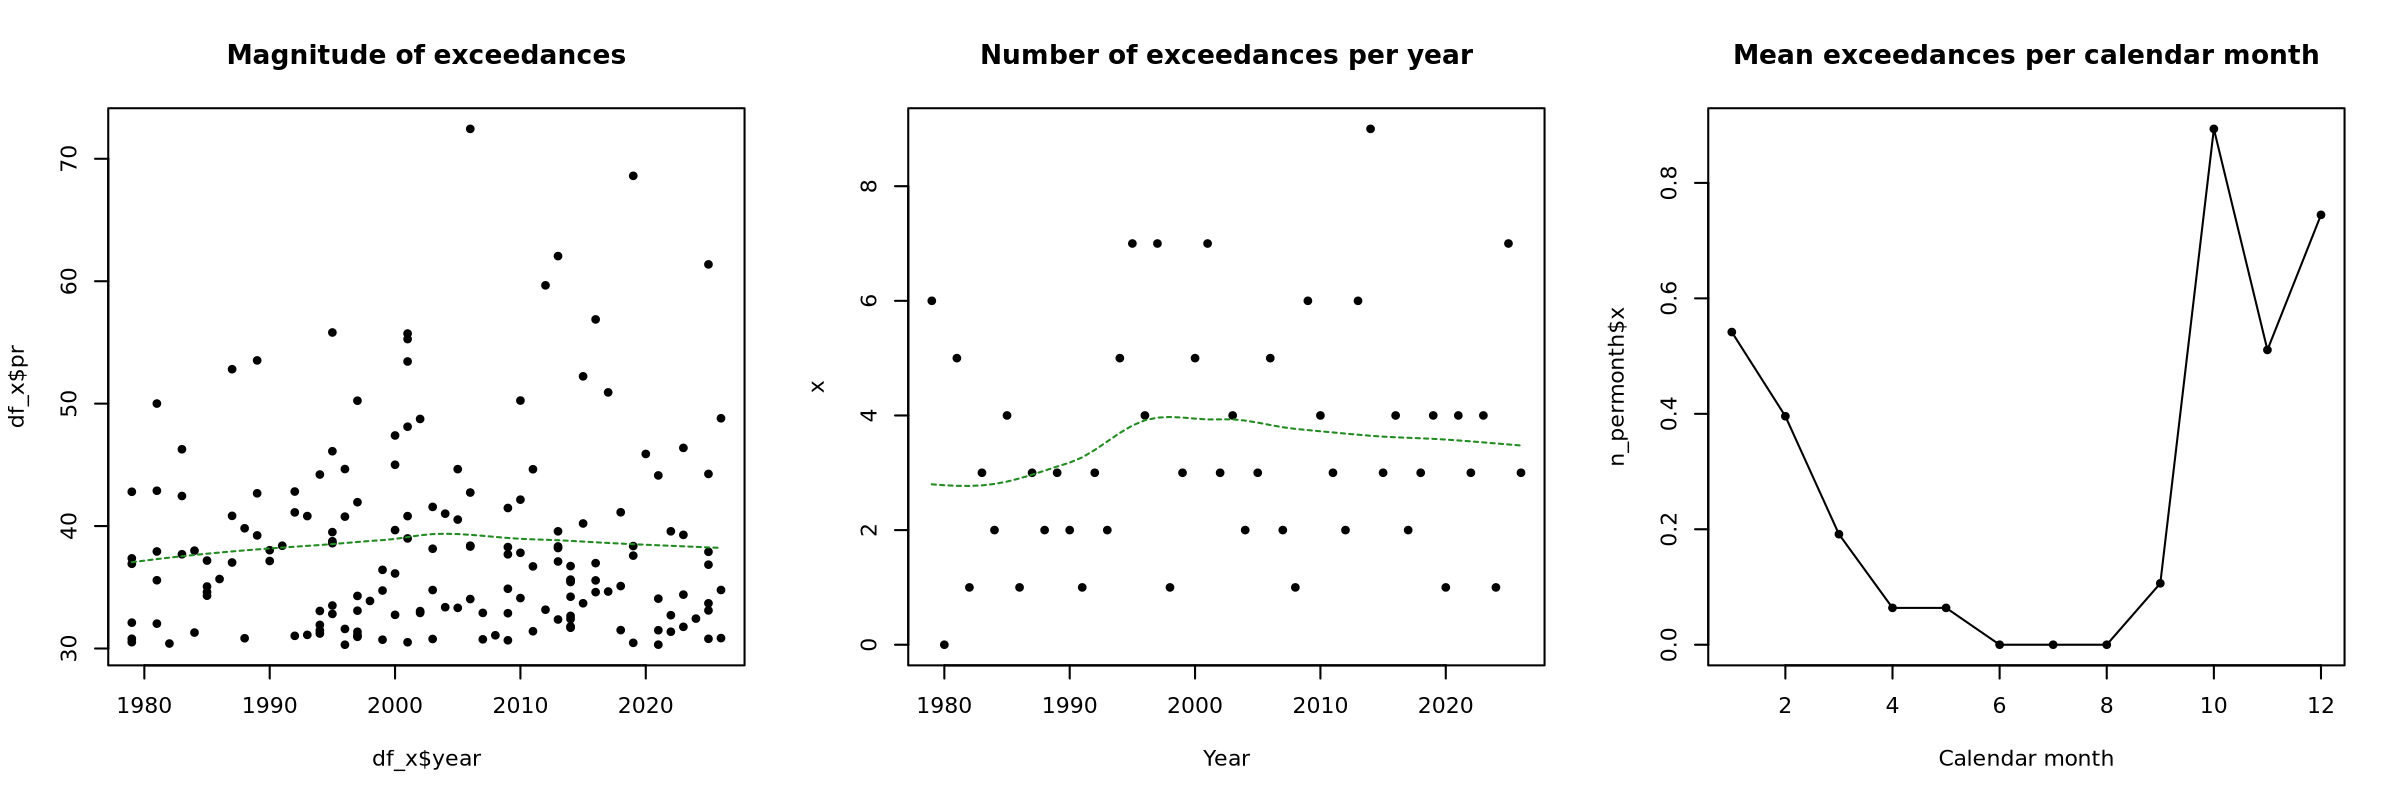

In [161]:
prep_window(c(1,3))
plot(df_x$year, df_x$pr, main = "Magnitude of exceedances")
lines(df_x$year, fitted(loess(pr ~ year, df_x)), col = "forestgreen", lty = "22") # add a smoother through number of exceedances

plot(n_peryear, main = "Number of exceedances per year", xlab = "Year")
lines(n_peryear$year, fitted(loess(x ~ year, n_peryear)), col = "forestgreen", lty = "22") # add a smoother through number of exceedances

plot(n_permonth$cmonth, n_permonth$x, main = "Mean exceedances per calendar month", xlim = c(1,12), xlab = "Calendar month", type = "o")

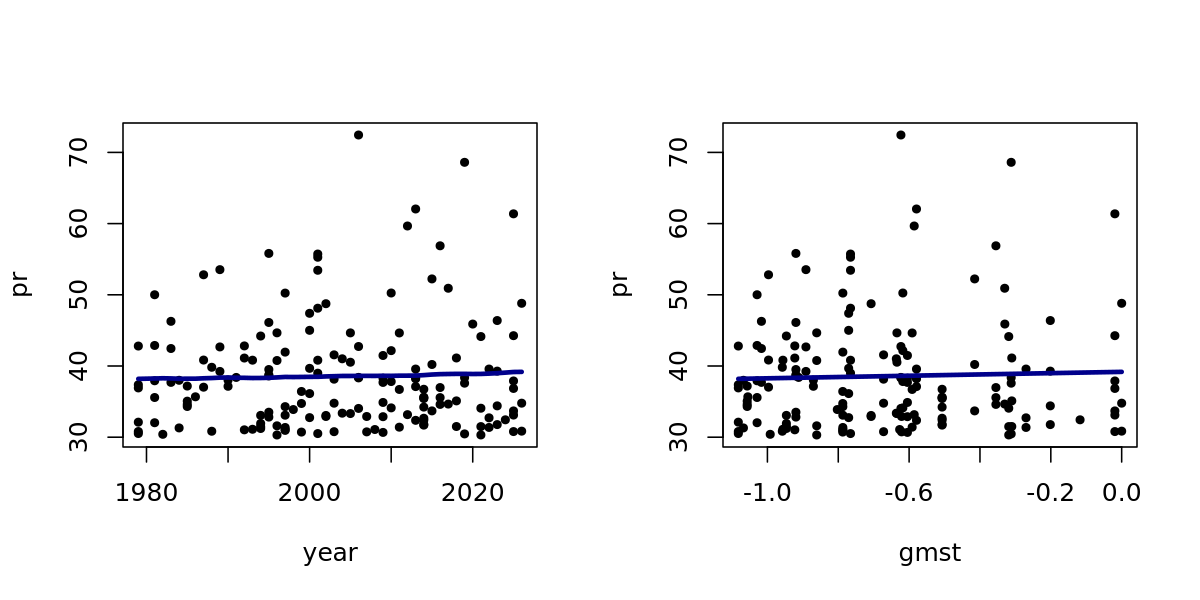

In [162]:
prep_window(c(1,2), res = 150)

plot(df[df$pr >= qq["99%"],c("year", "pr")])
lines(df[df$pr >= qq["99%"],c("year")], fitted(lm(pr ~ gmst, df[df$pr >= qq["99%"],c("gmst", "pr")])), lwd = 3, col = "darkblue")

plot(df[df$pr >= qq["99%"],c("gmst", "pr")])
lines(df[df$pr >= qq["99%"],c("gmst")], fitted(lm(pr ~ gmst, df[df$pr >= qq["99%"],c("gmst", "pr")])), lwd = 3, col = "darkblue")

## Point process model

In [163]:
df_dc <- decluster(df$pr, threshold = qq["99%"], r = 1)

In [164]:
mdl3 <- fevd(df_dc, data = data.frame(df_dc = c(df_dc), gmst = df$gmst), threshold = qq["99%"], location.fun = ~gmst, type = "PP")

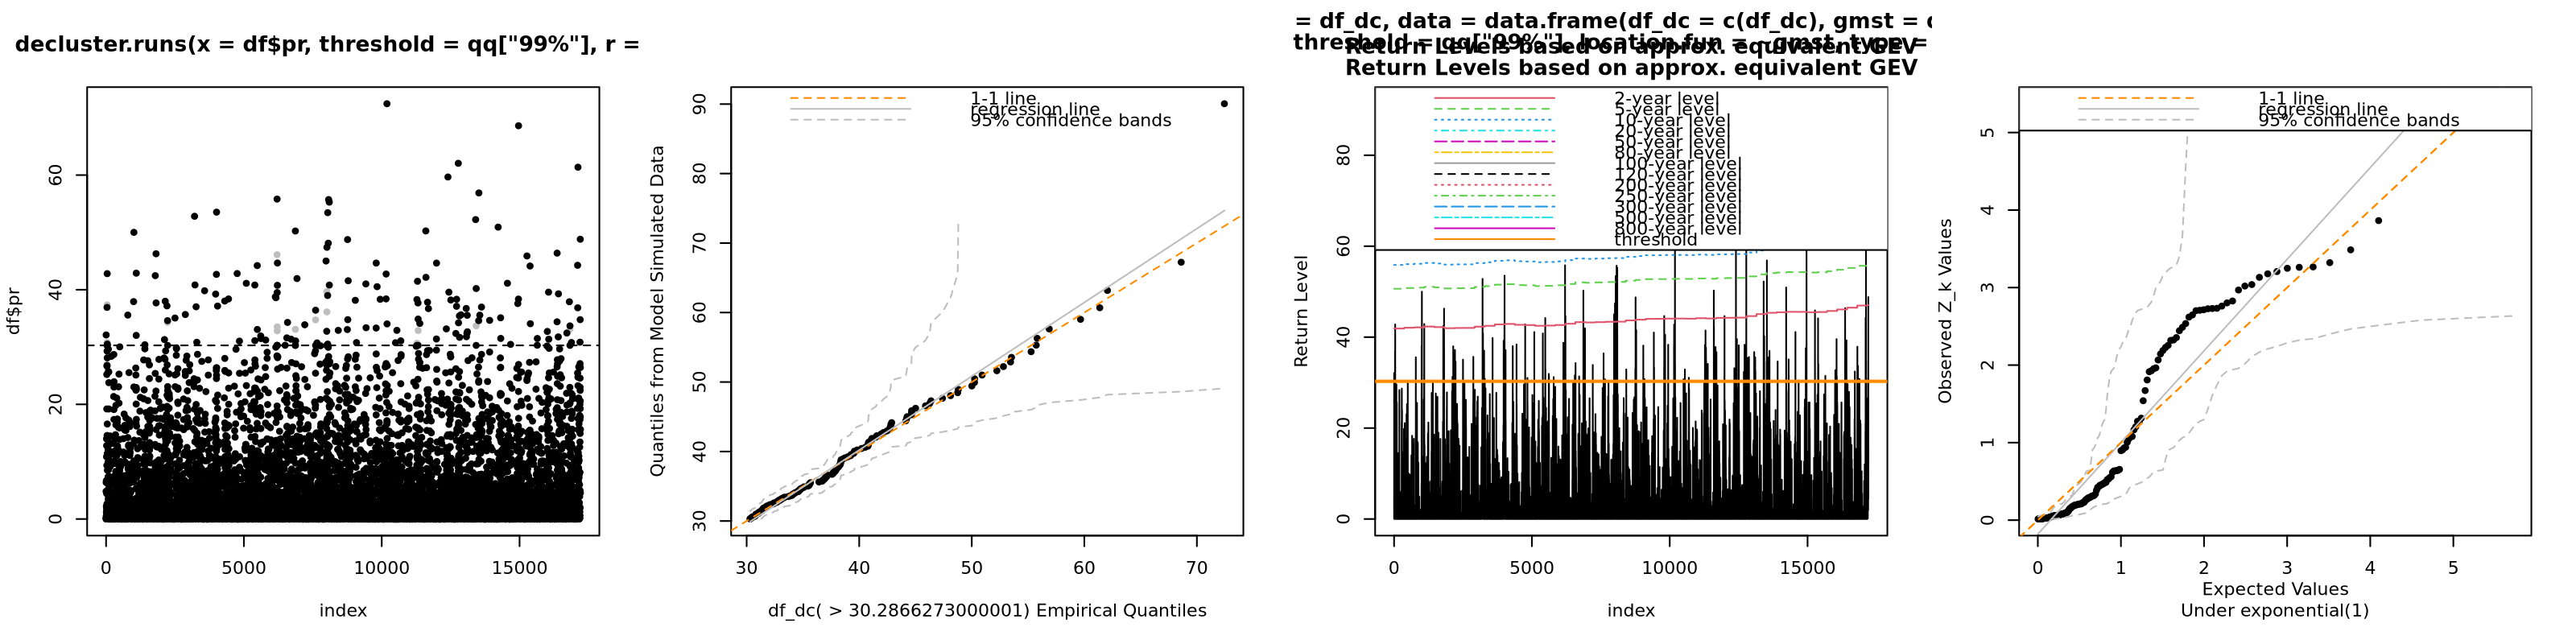

In [165]:
prep_window(c(1,4))
plot(df_dc)                        # very little declutering needed - 1-day captures the maxima fairly well
plot(mdl3, type = "qq2")
plot(mdl3, type = "rl")            # no evidence of trends in exceedances
plot(mdl3, type = "Zplot")         

## Generalised Pareto

In [166]:
mdl1 <- fevd(df_dc, data = data.frame(df_dc = c(df_dc), gmst = df$gmst), threshold = qq["99%"], location.fun = ~gmst, type = "GP")

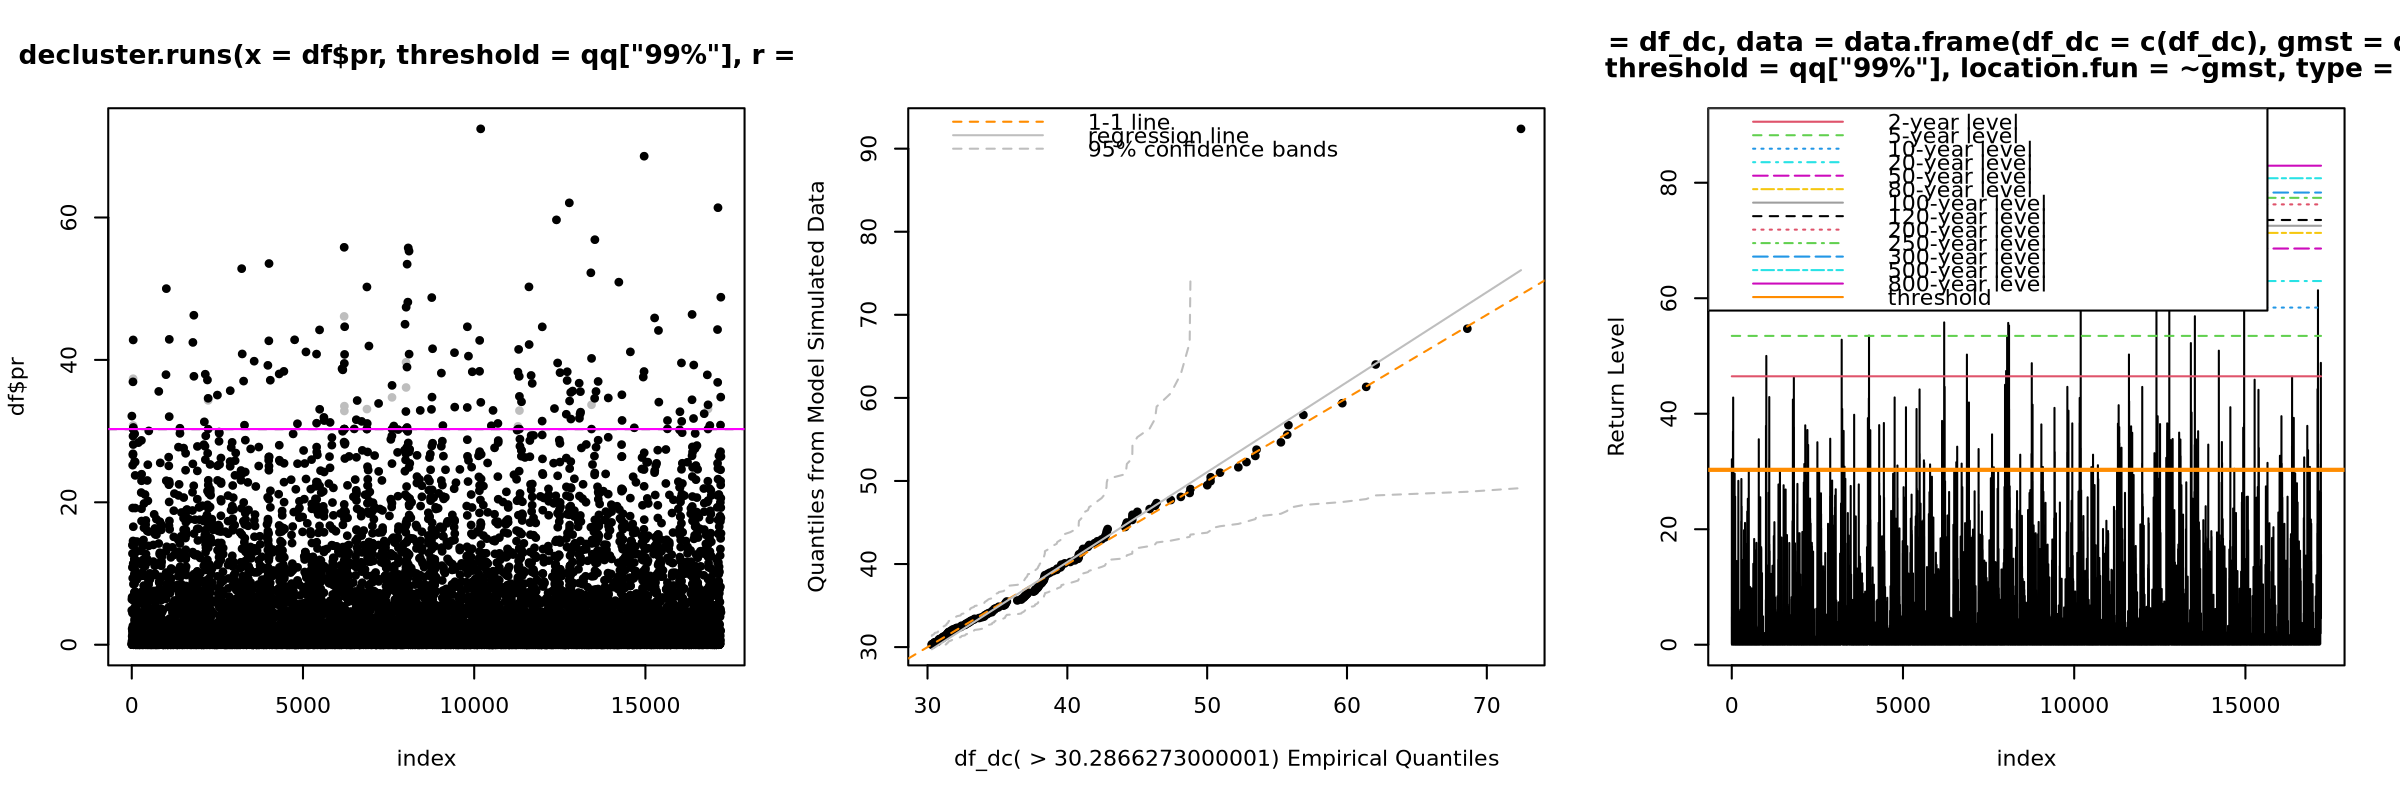

In [167]:
prep_window(c(1,3))
plot(df_dc)
abline(h = qq["99%"], col = "magenta")
plot(mdl1, type = "qq2")
plot(mdl1, type = "rl")

## Quantile regression

Check if there's any trend we're missing in the bulk of the distribution

In [168]:
qq <- c(0.25,0.5,0.75,0.85,0.9,0.95,0.975,0.99, 0.995)
qr <- rq(pr ~ gmst, data = df, tau = qq)

qpred <- fitted(qr) #  get fitted quantiles

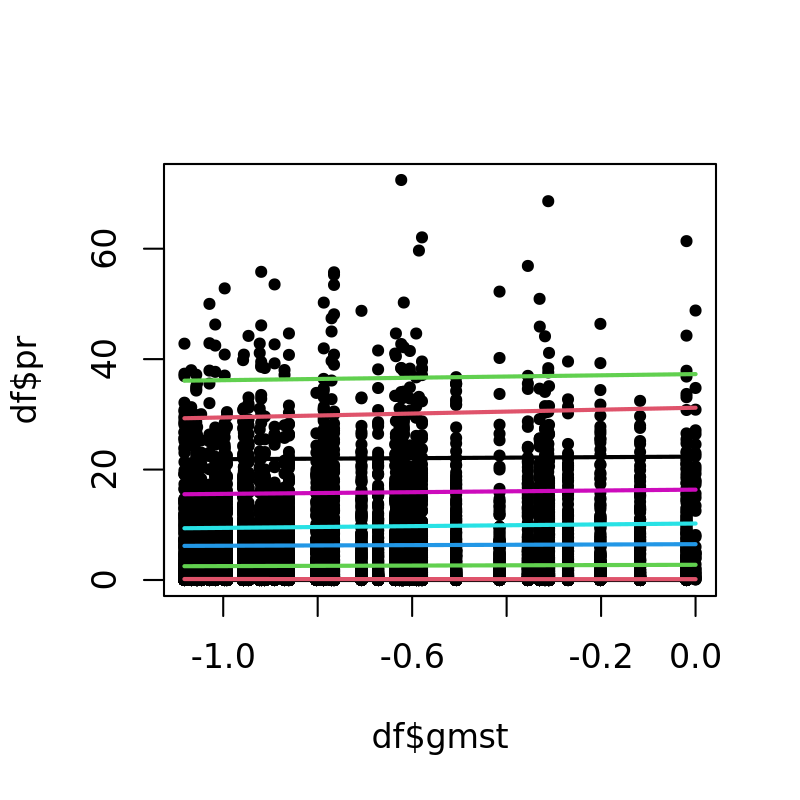

In [170]:
# no evidence of any change in quantiles of distribution
prep_window()
plot(df$gmst, df$pr)
matplot(df$gmst, qpred, add = T, type = "l", lty = 1, lwd = 2)

In [171]:
coef(qr)

,tau= 0.250,tau= 0.500,tau= 0.750,tau= 0.850,tau= 0.900,tau= 0.950,tau= 0.975,tau= 0.990,tau= 0.995
(Intercept),0.002140298,0.14913434,2.7512357,6.4881132,10.226518,16.3636035,22.3418671,31.202495,37.291249
gmst,-0.000586596,-0.02571498,0.2335449,0.2860742,0.785991,0.7675446,0.4639777,1.763551,1.103169
